# Power law? Or just a guideline?

I try not to get too invested in debates about whether an observed distribution follows a power law or not.

For one thing, nothing in the real world actually follows a power law, or any other simple mathematical model.
Sometimes we see distributions in real data that are well modeled by a power law distribution, but the data always deviate from the model -- and the same is true for other statistical models.
For example, nothing in the real world is actually sampled from a Gaussian distribution, but many things are well modeled by one.

It's not useful to ask whether a dataset actually came from a particular model, but it is useful to ask whether a particular model describes a dataset well -- and whether one fits a dataset better than another.

Statistical models are useful for many things, but the one I want to focus on in this discussion is the insight a model can provide into the data generating process.

For example, if we find that real data is well modeled by a Gaussian distribution, that suggests that the data are generated by a process that involves the sum of many random factors.
If we find that the data is well modeled by a lognormal, that suggests the data are the product of many factors.
And if we find that the data is well modeled by a power law distribution, there are several mechanisms that might explain it.

With that in mind, let's think about what kind of evidence supports the claim that data are well modeled by a power law distribution.

1. In the early days, researchers often plotted the PMF of the data on a log-log scale, and if it fell on a straight line over some part of the domain, they would declare a power law. But because PMFs are noisy, data from several other distributions would pass this test. So this approach is deprecated.

2. A more discriminating alternative is to plot the tail distribution (complementary CDF) on a log-log scale. A straight line on this plot, over some part of the domain, suggests a power law tail.

3. An even more discriminating option is to fit several statistical models to the data and compute a goodness of fit metric. If a power law distribution fits the data better than other models, over some part of the domain, that is stronger evidence of power law behavior. A challenge of this approach is that the results depend on which models are considered, how they are fit to the data, over what part of the domain they are evaluated, and what metric is used to compare the fit.

4. In addition, some researchers use null-hypothesis significance testing to check whether we can reject the hypothesis that the data actually came from the model. In my opinion, this approach is never useful, because we know that real data never come from a statistical model. If we have enough data, we will always reject the null hypothesis. If we fail to reject, that  only means we don't have enough data to distinguish between randomness and the inevitable differences between model and reality.

In a [recent paper](https://www.mdpi.com/1099-4300/27/6/561), Hatton and Warr argue that many discrete systems (made of distinguishable components like amino acids in proteins or tokens in computer code) share emergent global properties that can be explained by the Conservation of Hartley–Shannon Information (CoHSI) embedded in a statistical mechanics framework.

Because these properties appear regardless of system provenance (biological or human-made), Hatton and Warr suggest they do not depend on local mechanisms such as natural selection (in biology) or programmer intent (in software).

They consider two datasets:

* Proteins: TrEMBL database (versions spanning 10+ years; up to 251 million proteins).

* Software: 83.5M lines of open-source C code (Linux kernel, BSD, Apache, etc.).

To support the claim that these values follow a power law distribution:

1. They show that, for both protein lengths and software function lengths, the tail distribution (CCDF) has a section in the middle that looks roughly straight on a log-log scale, and

2. They use the poweRlaw R package package, which uses maximum-likelihood fitting, bootstrapped goodness-of-fit tests, and model comparisons to check whether the observed distributions are statistically consistent with a power law.

A limitation of this package is that it does not consider the Student t distribution as an alternative to the power law.
In [previous work](https://www.allendowney.com/blog/2023/11/29/superbolts/), I have found that the t distribution (on a log scale) is often a good model of data that appears to follow a power law.
And it has the advantage that it fits the entire distribution well, not just the tail.

So let's see what we can do with this dataset.
**Many thanks to Hatton and Warr for making the data available and providing the scripts they used to process the data.**

In [1]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate
from utils import empirical_error_bounds
from utils import plot_error_bounds

In [4]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## Data

First, let's download the data and supporting scripts from Hatton's site.

In [5]:
download(
    "http://www.leshatton.org/Documents/HattonWarr_SharedProps_Apr2025.zip"
)

Here are the files in the zip archive.

In [6]:
import zipfile

zip_path = "HattonWarr_SharedProps_Apr2025.zip"

with zipfile.ZipFile(zip_path, 'r') as zf:
    file_list = zf.namelist()

Here's the script that generates the PMF of token lengths.

In [7]:
target_file = "3-fig5AB.sh"

with zipfile.ZipFile(zip_path, 'r') as zf:
    with zf.open(target_file) as f:
        # Read as bytes and decode to string
        contents = f.read().decode("utf-8")

We can put the results in a DataFrame.

In [8]:
target_file = "pdf_c_ti.dat"

with zipfile.ZipFile(zip_path, "r") as zf:
    with zf.open(target_file) as f:
        df = pd.read_csv(
            f,
            comment="#",        # skip header lines starting with '#'
            delim_whitespace=True,
            names=["value", "freq"]
        )

Before we do anything else, let's compute the log of the token lengths.

In [9]:
df['mag'] = np.log10(df['value'])
df.head()

value  freq       mag
0     15   108  1.176091
1     16   191  1.204120
2     17   794  1.230449
3     18  1140  1.255273
4     19  1730  1.278754

And the total number of values.

In [10]:
count = df['freq'].sum()
count

1023772

Here's a `Pmf` of the magnitudes.

In [11]:
from empiricaldist import Pmf

pmf = Pmf(df['freq'].values, df['mag'])
pmf.normalize()

1023772

The following function computes the tail distribution (fraction of values >= x for all x).

In [12]:
from empiricaldist import Pmf, Surv


def make_surv(pmf):
    """Make a non-standard survival function, P(X>=x)"""
    surv = pmf.make_surv() + pmf

    # correct for numerical error
    surv.iloc[0] = 1
    return Surv(surv)

Here's what it looks like.

In [13]:
surv = make_surv(pmf)

In [14]:
xlabel = "Number of tokens (log10)"
ylabel = "Prob >= $x$"

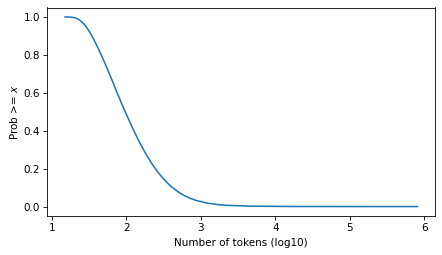

In [15]:
surv.plot()

decorate(xlabel=xlabel, ylabel=ylabel)

And here it is on a log scale.

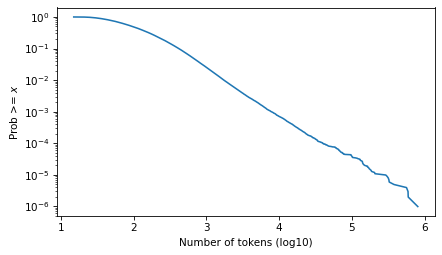

In [16]:
surv.plot()

decorate(xlabel=xlabel, ylabel=ylabel, yscale='log')
plt.savefig("ctokens1.png", dpi=300)

## Fit a Power Law

Select the part of the curve that looks like a straight line.

In [17]:
low, high = -1, -5
ps = np.logspace(low, high, 20)
qs = surv.inverse(ps)

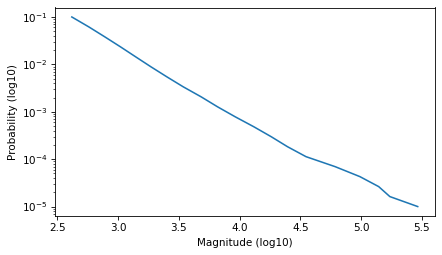

In [18]:
plt.plot(qs, ps)
decorate(xlabel='Magnitude (log10)', ylabel='Probability (log10)', yscale='log')

And fit a line to it.

In [19]:
from scipy.stats import linregress

log_ps = np.log10(ps)
result = linregress(qs, log_ps)
result

LinregressResult(slope=-1.4136537377903284, intercept=2.587287741048755, rvalue=-0.9976281753065604, pvalue=2.236547758622681e-22, stderr=0.022989880175375097, intercept_stderr=0.09297463728347397)

Extend the line to the full domain.

In [20]:
log_ps_ext = result.intercept + result.slope * surv.qs
ps_ext = np.power(10, log_ps_ext)

surv_power_law = Surv(ps_ext, surv.qs)

Here's what it looks like on a log-log scale.

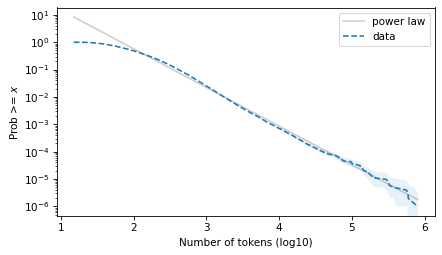

In [21]:
surv_power_law.plot(color='gray', alpha=0.4, label='power law')

plot_error_bounds(surv, count, color="C0")
surv.plot(ls='--', label="data")

decorate(xlabel=xlabel, ylabel=ylabel, yscale='log')
plt.savefig("ctokens2.png", dpi=300)

And on a linear y scale.

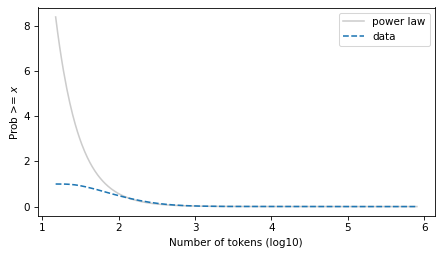

In [22]:
surv_power_law.plot(color='gray', alpha=0.4, label='power law')
surv.plot(ls='--', label='data')

decorate(xlabel=xlabel, ylabel=ylabel)
plt.savefig("ctokens4.png", dpi=300)

Compute residuals as differences in log survival function.

In [23]:
resid_power_law = np.log10(surv_power_law.ps) - np.log10(surv.ps)

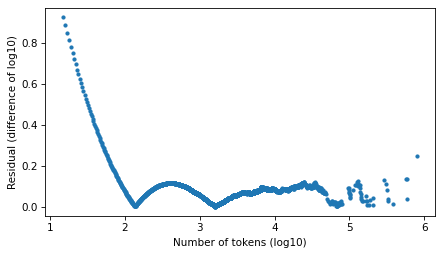

In [24]:
plt.plot(surv.qs, np.abs(resid_power_law), '.')

decorate(xlabel=xlabel, ylabel='Residual (difference of log10)')

## Fit a Student t

First we'll find the `df` parameter that best matches the tail, then the `mu` and `sigma` parameters that best match the percentiles.

In [25]:
from scipy.stats import t as t_dist


def truncated_t_sf(qs, df, mu, sigma):
    ps = t_dist.sf(qs, df, mu, sigma)
    surv_model = Surv(ps / ps[0], qs)
    return surv_model

In [26]:
from scipy.optimize import least_squares


def fit_truncated_t(df, surv):
    """Given df, find the best values of mu and sigma."""
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high, 1000)

    # match 20 percentiles from 1st to 99th
    ps = np.linspace(0.01, 0.99, 20)
    qs = surv.inverse(ps)

    def error_func_t(params, df, surv):
        mu, sigma = params
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        error = surv(qs) - surv_model(qs)
        return error

    params = surv.mean(), surv.std()
    res = least_squares(error_func_t, x0=params, args=(df, surv), xtol=1e-3)
    assert res.success
    return res.x

In [27]:
from scipy.optimize import minimize


def minimize_df(df0, surv, bounds=[(1, 1e6)], ps=None):
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high * 1.0, 2000)

    if ps is None:
        # fit the tail over these orders of magnitude
        ps = np.logspace(-1, -5, 20)

    qs = surv.inverse(ps)

    def error_func_tail(params):
        (df,) = params
        mu, sigma = fit_truncated_t(df, surv)
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        errors = np.log10(surv(qs)) - np.log10(surv_model(qs))
        return np.sum(errors**2)

    params = (df0,)
    res = minimize(error_func_tail, x0=params, bounds=bounds, tol=1e-3, method="Powell")
    assert res.success
    return res.x

Search for the value of df that best matches the tail behavior.

In [28]:
df = minimize_df(5, surv, [(1, 100)])
df

array([8.72600852])

Given that value of `df`, find `mu` and `sigma` to best match percentiles.

In [29]:
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([8.72600852]), 1.9668595666488846, 0.42974985890124023)

Evaluate the model over the range of the data.

In [30]:
surv_model = truncated_t_sf(surv.qs, df, mu, sigma)

The t distribution fits the data well over the entire domain -- although there is some daylight between the model and the data at the left tail.

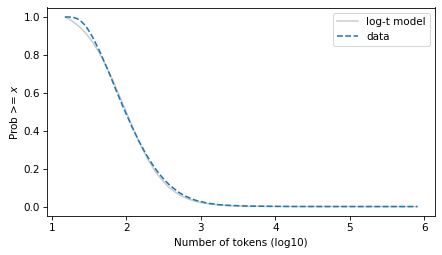

In [31]:
surv_model.plot(color="gray", alpha=0.4, label="log-t model")
surv.plot(ls="--", label="data")

decorate(xlabel=xlabel, ylabel=ylabel)
plt.savefig("ctokens4.png", dpi=300)

And the tail behavior looks good on a log scale, although there is some daylight at the extreme right tail.

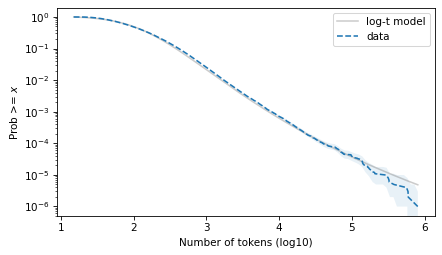

In [32]:
surv_model.plot(color="gray", alpha=0.4, label="log-t model")
surv.plot(ls="--", label="data")

plot_error_bounds(surv, count, color="C0")

decorate(xlabel=xlabel, ylabel=ylabel, yscale="log")
plt.savefig("ctokens5.png", dpi=300)

Let's compare residuals, using the difference in the tail distribution on a log scale.

In [33]:
resid_t = np.log10(surv_model.ps) - np.log10(surv.ps)

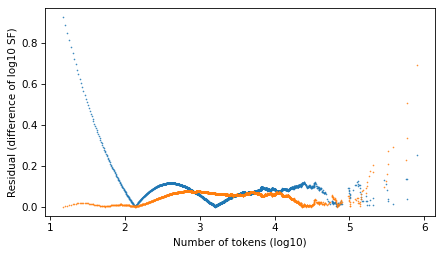

In [34]:
plt.plot(surv.qs, np.abs(resid_power_law), '.', ms=1)
plt.plot(surv.qs, np.abs(resid_t), '.', ms=1)

decorate(xlabel=xlabel, ylabel='Residual (difference of log10 SF)')
plt.savefig("ctokens6.png", dpi=300)

Looking at the residuals, there is no clear winner.
In the extreme right tail, the power law model is better.
In the middle, they are about the same.
In the left part of the distribution, the Student t model is substantially better -- but people who argue in favor of power laws usually assert that they only apply to the tail.

These results are consistent with what I've seen in other datasets.
The Student t model fits the tail as well or better than the power law model, and has the advantage of fitting the entire distribution well.

When the t model fits data well, it suggests a model of the data generating process.
A t distribution is a mixture of Gaussians with different variance -- and Gaussians come from the sum of many random factors.

Or when we see a t distribution on a log scale, as in these datasets, it suggests that the data generating process is a mixture of lognormals with different variance, where each lognormal comes from the product of random factors.

Allen Downey
[MIT License](https://mit-license.org/)